[View in Colaboratory](https://colab.research.google.com/github/t-kinosi/OpenCV-HandsOn/blob/master/OpenCV_HandsOn.ipynb)

# 準備(インポート/Google colab用にファイルを用意)

In [0]:
import cv2
import numpy as np
from IPython.display import display, Image

def imshow(img, format='.png'):
  img=cv2.resize(img,(256,256))
  decoded_bytes = cv2.imencode(format, img)[1].tobytes()
  display(Image(data=decoded_bytes))
  
def imresize(img):
  h, w,_ = img.shape
  h, w = int(h/2), int(w/2)
  short = h if h <= w else w
  return cv2.resize(img[h-short:h+short, w-short:w+short], (512,512))

インポートと，  
インラインで表示を簡単にするための関数  imshow  [ここを参考にした](http://uphy.hatenablog.com/entry/2016/12/11/110703)  
(普通はmatplotlibを使うなど，色空間の変換が必要になってきます．今回は簡略のためこの関数を使います．)  
入力する画像が長方形だったときに短辺基準で正方形(512,512)にする関数 imresize

In [471]:
import urllib.request
urllib.request.urlretrieve('http://optipng.sourceforge.net/pngtech/img/lena.png', 'lena.png')
urllib.request.urlretrieve('https://s3-ap-northeast-1.amazonaws.com/life-static-production/wp-content/uploads/2016/12/30155528/img_119138_4-668x430.png', 'cake.png')
urllib.request.urlretrieve('http://cdn-ak.f.st-hatena.com/images/fotolife/M/Martin-S/20151124/20151124221858.png', 'sea.png')
urllib.request.urlretrieve('https://upload.wikimedia.org/wikipedia/commons/f/f1/Pomeranian-tb.png', 'dog.png')

('dog.png', <http.client.HTTPMessage at 0x7fd47bbdaac8>)

いくつかテスト画像をダウンロードしてきます

In [0]:
 # from google.colab import files
 # f = files.upload()

任意のファイルをアップロードして使うこともできます

In [473]:
!ls -l
# !rm *.png    # 削除

total 7136
-rw-r--r-- 1 root root  496210 Jul  9 09:31 cake.png
drwxr-xr-x 3 root root    4096 Jul  3 16:57 datalab
-rw-r--r-- 1 root root 1614939 Jul  9 09:31 dog.png
-rw-r--r-- 1 root root  473831 Jul  9 09:31 lena.png
-rw-r--r-- 1 root root 4707907 Jul  9 09:31 sea.png


ファイルの存在を確認 ( !~~でコマンドが使えるみたいです ．!pipとかもいけます)


# OpenCVで基本的な入出力
[OpenCVリファレンス](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_gui/py_image_display/py_image_display.html)

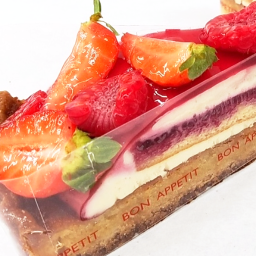

In [474]:
img = cv2.imread("cake.png")    # サンプル
img = imresize(img)
imshow(img)

**cv2.imread(image)** で画像読み込みを行う  
読み込んだ画像を表示して確認

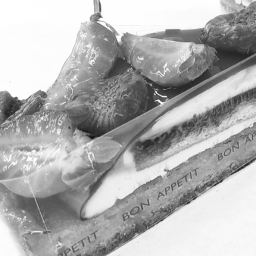

In [475]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(img_gray)

**cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)** でグレー画像に変換できる  
色空間変換コードは[いろいろあります](https://docs.opencv.org/3.4.0/d7/d1b/group__imgproc__misc.html#ga4e0972be5de079fed4e3a10e24ef5ef0)．
よく使うのはRGB, BGR, HSV, GRAYとか．

In [0]:
# cv2.imwrite('gray.png', img_gray)
# !ls -l

**cv2.imwrite(file name, image)** でファイルを保存できる  

# [フーリエ変換による周波数フィルタリング](https://algorithm.joho.info/image-processing/fourier-transform/)

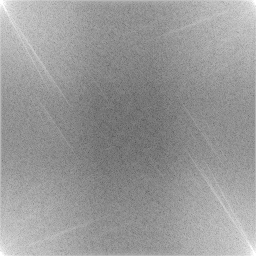

In [477]:
fimg = np.fft.fft2(img_gray)    # 高速フーリエ変換
mag = 20*np.log(np.abs(fimg))    # パワースペクトル変換
imshow(mag)

上のグレー画像をフーリエ変換した結果↑  
普通にフーリエ変換すると，下図の←のように低周波が四角に集まるらしい．  
下図の→のように象限を入れ替えて低周波を真ん中に集めると使いやすい．  
![dd](https://algorithm.joho.info/wp-content/img/algorizm/image-processing/frequency/fft/2.png =x200)

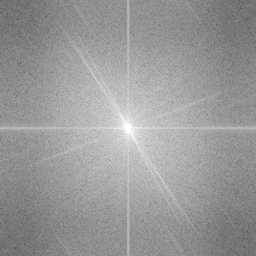

In [478]:
fimg = np.fft.fftshift(fimg)    # 1,3と2,4象限を入れ替える
mag = 20*np.log(np.abs(fimg))    # パワースペクトル変換
imshow(mag)

象限を入れ替えると，低周波が中心に集まったことを確認

## ローパスフィルタ

### フィルタ作成  
周波数領域の一部を切り抜くことで，周波数フィルタを作成できる．  
ローパスフィルタでは，中心部のみを残す．

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


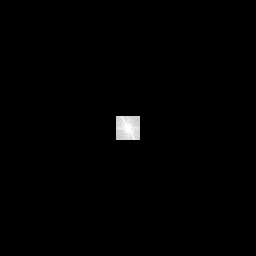

In [479]:
a = 0.1    # フィルタの大きさを決める変数
h, w = img_gray.shape    # 画像サイズ取得
cy, cx = int(h/2), int(w/2)    # 中心座標を取得
rh, rw = int(a*cy), int(a*cx)    # フィルタのサイズを定義
lf = np.zeros((h,w), dtype=complex)
lf[cy-rh:cy+rh, cx-rw:cx+rw] = fimg[cy-rh:cy+rh, cx-rw:cx+rw]    # 中心部だけ代入ほかは0 =ローパス
mag = 20*np.log(np.abs(lf))    # パワースペクトル変換
imshow(mag)

### 空間領域に戻してみる

ローパスフィルタ↓


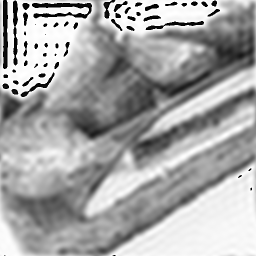

元画像↓


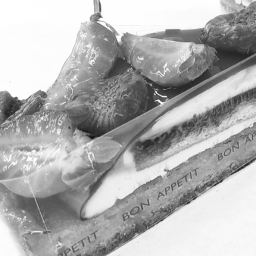

In [480]:
lf = np.fft.fftshift(lf)     # 象限をもとに戻す
lf = np.fft.ifft2(lf)    # フーリエ逆変換
img_l = np.uint8(lf.real)
print('ローパスフィルタ↓')
imshow(img_l)
print('元画像↓')
imshow(img_gray)

## ハイパスフィルタ

### フィルタ作成  
ハイパスフィルタは中心を消す

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


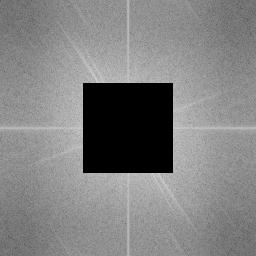

In [481]:
a = 0.35    # フィルタの大きさを決める変数
h, w = img_gray.shape    # 画像サイズ取得
cy, cx = int(h/2), int(w/2)    # 中心座標を取得
rh, rw = int(a*cy), int(a*cx)    # フィルタのサイズを定義
hf = fimg.copy()        # 元の周波数領域をコピー
hf[cy-rh:cy+rh, cx-rw:cx+rw] = 0    # 中心部だけ0 =ハイパス
mag = 20*np.log(np.abs(hf))    # パワースペクトル変換
imshow(mag)

### 空間領域に戻してみる

ハイパスフィルタ↓


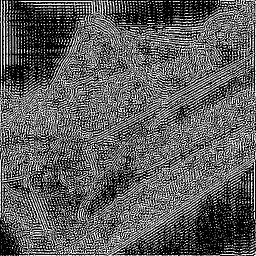

元画像↓


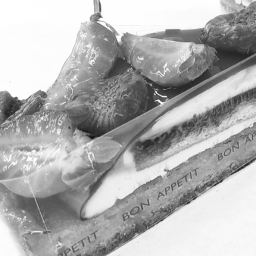

In [482]:
hf2 = np.fft.fftshift(hf)     # 象限をもとに戻す
hf2 = np.fft.ifft2(hf2)    # フーリエ逆変換
img_h = np.uint8(hf2.real)
print('ハイパスフィルタ↓')
imshow(img_h)
print('元画像↓')
imshow(img_gray)

## 高域強調フィルタ

### フィルタ作成

ハイパスフィルタ↓


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


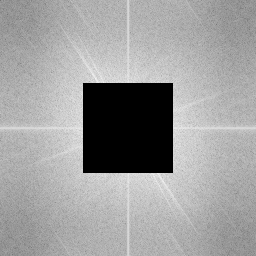

元画像↓


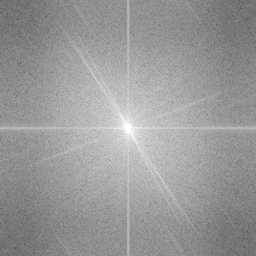

足し合わせたもの↓


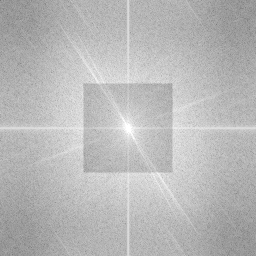

In [483]:
hef = 5*hf[:] + fimg[:]
mag = 20*np.log(np.abs(5*hf))
print('ハイパスフィルタ↓')
imshow(mag)
mag = 20*np.log(np.abs(fimg))
print('元画像↓')
imshow(mag)
mag = 20*np.log(np.abs(hef))
print('足し合わせたもの↓')
imshow(mag)

### 空間領域に戻してみる  
高周波数の部分がより強くなっていることがわかる

高域強調フィルタ↓


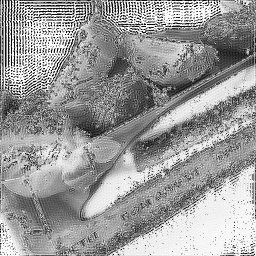

元画像↓


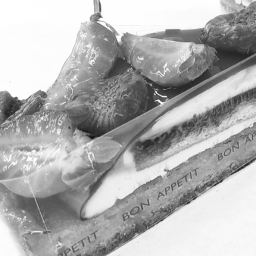

In [484]:
hef = np.fft.fftshift(hef)     # 象限をもとに戻す
hef = np.fft.ifft2(hef)    # フーリエ逆変換
img_he = np.uint8(hef.real)
print('高域強調フィルタ↓')
imshow(img_he)
print('元画像↓')
imshow(img_gray)

## バンドパスフィルタ

### フィルタ作成  
ローパスフィルタで中心を残したあとにハイパスフィルタで中抜きする感じ

89


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


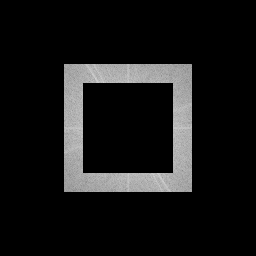

In [485]:
low = 0.5
high = 0.35    # low > high
h, w = img_gray.shape
cy, cx = int(h/2), int(w/2)
rhl, rwl = int(low*cy), int(low*cx)
rhh, rwh = int(high*cy), int(high*cx)
bf = np.zeros((h,w), dtype=complex)
bf[cy-rhl:cy+rhl, cx-rwl:cx+rwl] = fimg[cy-rhl:cy+rhl, cx-rwl:cx+rwl]
bf[cy-rhh:cy+rhh, cx-rwh:cx+rwh] = 0
print(rwh)
mag = 20*np.log(np.abs(bf))
imshow(mag)

### 空間領域に戻してみる

バンドパスフィルタ↓


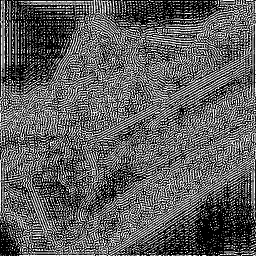

ハイパスフィルタ↓


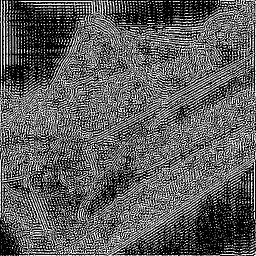

元画像↓


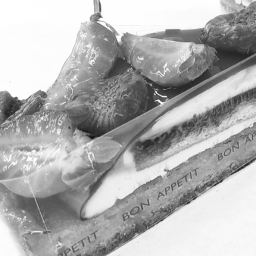

In [486]:
bf = np.fft.fftshift(bf)
bf = np.fft.ifft2(bf)
img_b = np.uint8(bf.real)
print('バンドパスフィルタ↓')
imshow(img_b)
print('ハイパスフィルタ↓')
imshow(img_h)
print('元画像↓')
imshow(img_gray)

# 空間フィルタリング


## 平滑化

### [平均化フィルタ](https://algorithm.joho.info/image-processing/average-filter-smooth/)


平均化フィルタ↓


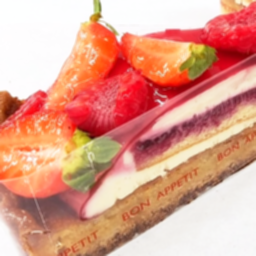

元画像↓


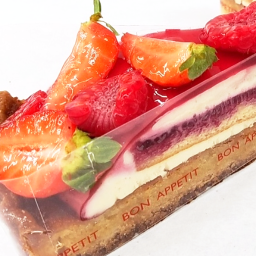

In [487]:
kernel_size = (5,5)
blur = cv2.blur(img, kernel_size)
print('平均化フィルタ↓')
imshow(blur)
print('元画像↓')
imshow(img)

[**cv.blur(image, kernel_size)**](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_filtering/py_filtering.html#id4)
でkernel_sizeの平均化フィルタを適用した画像を作れる  

### 加重平均化フィルタ

平均化フィルタ↓


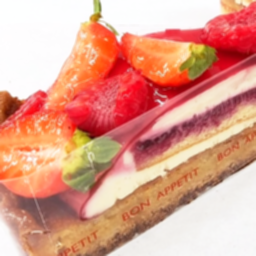

加重平均化フィルタ↓


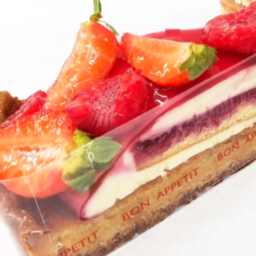

元画像↓


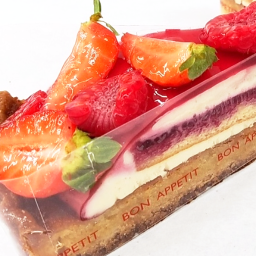

In [488]:
kernel = np.array([[1, 2, 4, 2, 1],
                   [2, 4, 8, 4, 2],
                   [4, 8, 16, 8, 4],
                   [2, 4, 8, 4, 2],
                   [1, 2, 4, 2, 1]]) / 100    # 自作フィルタ
blur_weighted = cv2.filter2D(img, -1, kernel)
print('平均化フィルタ↓')
imshow(blur)
print('加重平均化フィルタ↓')
imshow(blur_weighted)
print('元画像↓')
imshow(img)

[**cv2.filter2D(image, 出力のbit深度？, kernel)**](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_filtering/py_filtering.html#d-convolution)
 で自作フィルタkernelを適用した画像を作れる  

#### [Gaussian(ガウシアン)フィルタ](https://algorithm.joho.info/image-processing/gaussian-filter/)
ガウス分布で加重平均化フィルタを作成したもの

加重平均化フィルタ↓


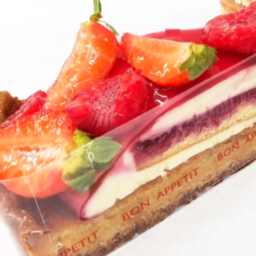

Gaussianフィルタ↓


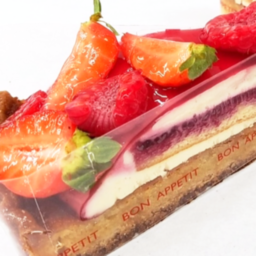

元画像↓


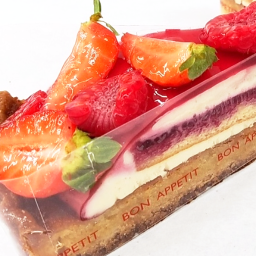

In [489]:
blur_gauss = cv2.GaussianBlur(img, kernel_size ,0)
print('加重平均化フィルタ↓')
imshow(blur_weighted)
print('Gaussianフィルタ↓')
imshow(blur_gauss)
print('元画像↓')
imshow(img)

[**cv.GaussianBlur(image, kernel_size, 0)**](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_filtering/py_filtering.html#id5)
 でガウス分布の加重平均化フィルタを適用することができる  

### [特定方向の平滑化](http://hiroyukitsuda.com/archives/2064)  
特定方向のみに重みをもたせたフィルターを適用すると，モーションブラーのような効果が得られる  

特定方向平滑化↓


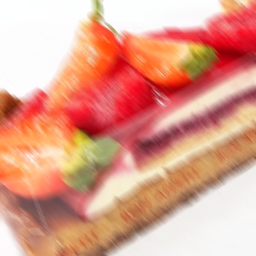

元画像↓


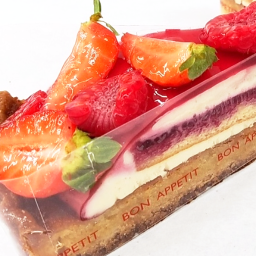

In [490]:
kernel_motion = np.diag([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]) / 15    # (15,15)の対角行列を生成，要素は1/15
blur_motion = cv2.filter2D(img, -1, kernel_motion)
print('特定方向平滑化↓')
imshow(blur_motion)
print('元画像↓')
imshow(img)

## エッジ抽出

### [1次微分フィルタ](https://algorithm.joho.info/image-processing/differential-filter/)

横方向1次微分フィルタ↓


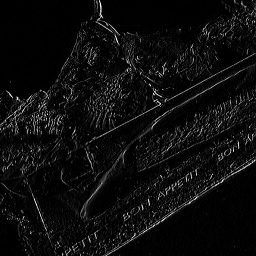

縦方向1次微分フィルタ↓


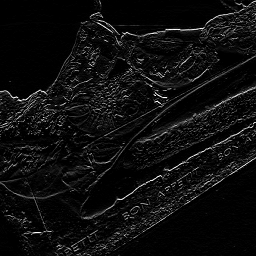

元画像↓


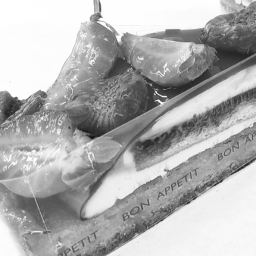

In [491]:
kernel_dx = np.array([[0, 0, 0],
                      [0, -1, 1],
                      [0, 0, 0]]) *5
kernel_dy = np.array([[0, 1, 0],
                      [0, -1, 0],
                      [0, 0, 0]]) *5
diff_x = cv2.filter2D(img_gray, -1, kernel_dx)
diff_y = cv2.filter2D(img_gray, -1, kernel_dy)
print('横方向1次微分フィルタ↓')
imshow(diff_x)
print('縦方向1次微分フィルタ↓')
imshow(diff_y)
print('元画像↓')
imshow(img_gray)

### 2次微分フィルタ

横方向2次微分フィルタ↓


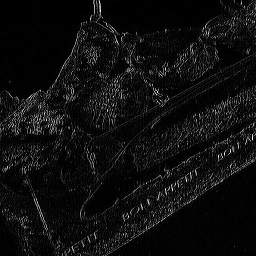

縦方向2次微分フィルタ↓


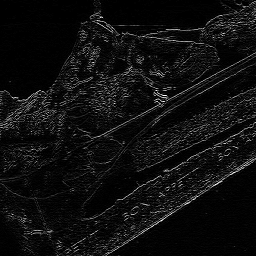

元画像↓


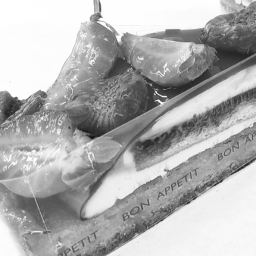

In [492]:
kernel_ddx = np.array([[0, 0, 0],
                       [1, -2, 1],
                       [0, 0, 0]]) *5
kernel_ddy = np.array([[0, 1, 0],
                       [0, -2, 0],
                       [0, 1, 0]]) *5
diff2_x = cv2.filter2D(img_gray, -1, kernel_ddx)
diff2_y = cv2.filter2D(img_gray, -1, kernel_ddy)
print('横方向2次微分フィルタ↓')
imshow(diff2_x)
print('縦方向2次微分フィルタ↓')
imshow(diff2_y)
print('元画像↓')
imshow(img_gray)

### [Prewitt(プレヴィット)フィルタ](https://algorithm.joho.info/image-processing/prewitt-filter/)
### [Sobel(ソーベル)フィルタ](https://algorithm.joho.info/image-processing/sobel-filter/)  
SobelフィルタはPrewittフィルタの改良版  
Sobelフィルタのほうが，輪郭の部分がより白くなっている．

prewittフィルタ↓


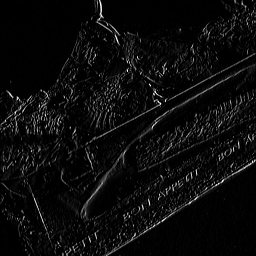

sobelフィルタ↓


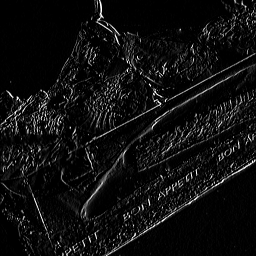

元画像↓


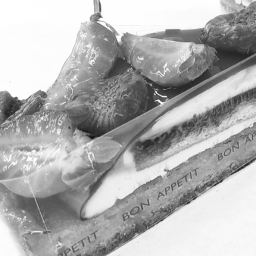

In [493]:
kernel_prewitt = np.array([[-1, 0, 1],
                           [-1, 0, 1],
                           [-1, 0, 1]])
kernel_sobel = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]])
prewitt = cv2.filter2D(img_gray, -1, kernel_prewitt)
sobel = cv2.filter2D(img_gray, -1, kernel_sobel)
print('prewittフィルタ↓')
imshow(prewitt)
print('sobelフィルタ↓')
imshow(sobel)
print('元画像↓')
imshow(img_gray)

### [Laplacian(ラプラシアン)フィルタ](https://algorithm.joho.info/image-processing/laplacian-filter/)

Laplacianフィルタ↓


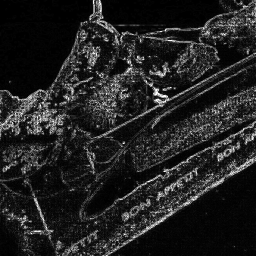

元画像↓


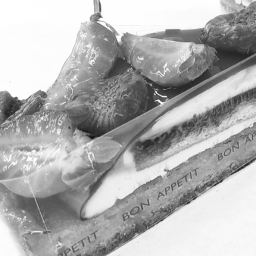

In [494]:
laplacian = cv2.Laplacian(img_gray, cv2.CV_32F, ksize=3)
laplacian = cv2.convertScaleAbs(laplacian)  # 8bit符号なしに変換
print('Laplacianフィルタ↓')
imshow(laplacian)
print('元画像↓')
imshow(img_gray)

[**cv2.Laplacian(image, cv2.CV_32F, ksize)**](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_gradients/py_gradients.html#laplacian)
でラプラシアンフィルタを適応した画像を作成できる  

## 先鋭化

### アンシャープマスキング
イメージ：元画像 ＋ (元画像－平滑化(元画像))

元画像と平滑化との差分↓


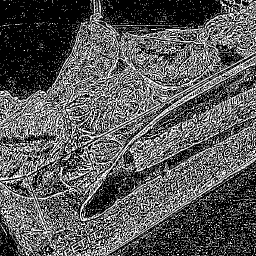

アンシャープマスキング↓


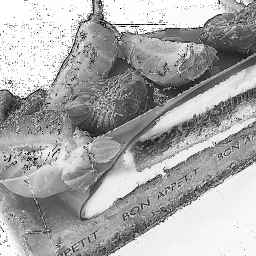

元画像↓


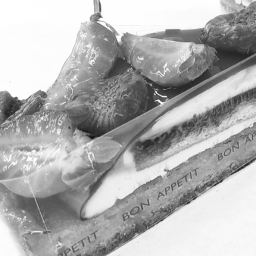

In [495]:
gauss_gray = cv2.GaussianBlur(img_gray, kernel_size ,0)
sharp_mask = img_gray - gauss_gray
img_sharp = img_gray + sharp_mask*3

print('元画像と平滑化との差分↓')
imshow(sharp_mask)
print('アンシャープマスキング↓')
imshow(img_sharp)
print('元画像↓')
imshow(img_gray)

### 先鋭化フィルタ
アンシャープマスキングをフィルタとして行うもの  
kを弄れば先鋭化のレベルを変えられる

先鋭化フィルタ↓


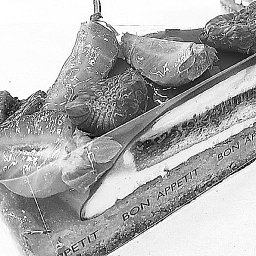

元画像↓


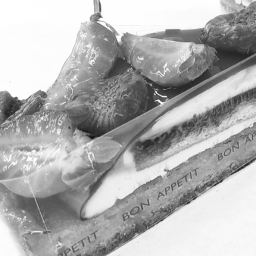

In [496]:
k = 9
kernel_sharp = np.array([[-1, -1, -1],
                         [-1, 1/9*k+8, -1],
                         [-1, -1, -1]]) * k / 9
img_sharpf = cv2.filter2D(img_gray, -1, kernel_sharp)
print('先鋭化フィルタ↓')
imshow(img_sharpf)
print('元画像↓')
imshow(img_gray)

## エッジを保存した平滑化(非線形フィルタ)
ノイズ除去などに使う

### [bilateral(バイラテラル)フィルタ](https://imagingsolution.net/imaging/bilateralfilter/)

元画像↓


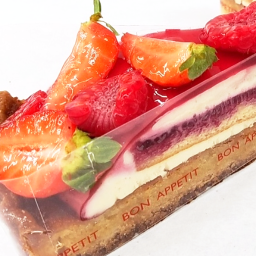

bilateralフィルタ1回↓


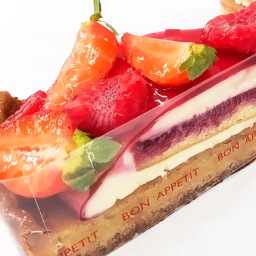

bilateralフィルタ3回↓


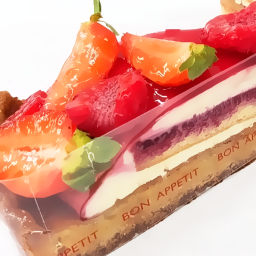

bilateralフィルタ5回↓


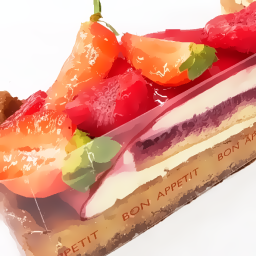

In [497]:
bi = cv2.bilateralFilter(img, 15, 20, 20)
bi2 = cv2.bilateralFilter(bi, 15, 20, 20)
bi3 = cv2.bilateralFilter(bi2, 15, 20, 20)
bi4 = cv2.bilateralFilter(bi3, 15, 20, 20)
bi5 = cv2.bilateralFilter(bi4, 15, 20, 20)


print('元画像↓')
imshow(img)
print('bilateralフィルタ1回↓')
imshow(bi)
print('bilateralフィルタ3回↓')
imshow(bi3)
print('bilateralフィルタ5回↓')
imshow(bi5)

[cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)](https://docs.opencv.org/3.0-last-rst/modules/imgproc/doc/filtering.html?highlight=laplacian#bilateralfilter)  
d: 注目画素をぼかすために使われる領域  
sigmaColor: 色についての標準偏差。これが大きいと、画素値の差が大きくても大きな重みが採用される。  
sigmaSpace: 距離についての標準偏差。これが大きいと、画素間の距離が広くても大きな重みが採用される。

###[**n-local mean(ノンローカルミーン)フィルタ**](https://qiita.com/shim0mura/items/f222082b7ef08de3732e#%E3%83%8E%E3%83%B3%E3%83%AD%E3%83%BC%E3%82%AB%E3%83%AB%E3%83%9F%E3%83%BC%E3%83%B3%E3%83%95%E3%82%A3%E3%83%AB%E3%82%BFnon-local-means-filter)

non-local meanフィルタ↓


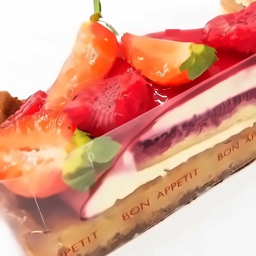

元画像↓


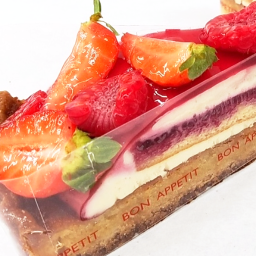

In [498]:
NLM = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

print('non-local meanフィルタ↓')
imshow(NLM)
print('元画像↓')
imshow(img)

[**cv2.fastNlMeansDenoisingColored(image, dst, h, hColor, templateWindowSize, searchWindowSize)**](https://docs.opencv.org/3.0-beta/modules/photo/doc/denoising.html#fastnlmeansdenoisingcolored)  
h: 輝度成分のフィルタの平滑化の度合い、大きいとノイズが減少するが、エッジ部にも影響する  
hColor: 色成分のフィルタの平滑化の度合い、10にしておけば十分  
templateWindowSize: 周辺領域のテンプレートサイズ  
searchWindowSize: 重みを探索する領域サイズ

### [**median(メディアン)フィルタ**](https://algorithm.joho.info/image-processing/median-filter/)
飛んでるノイズを除去できる



medianフィルタ↓


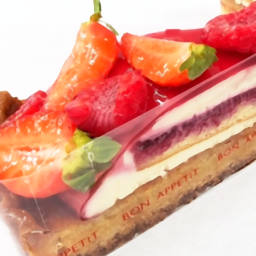

元画像↓


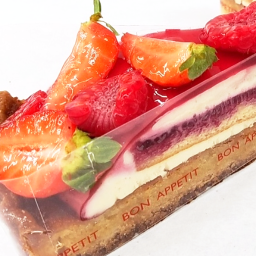

In [499]:
blur_median = cv2.medianBlur(img, ksize=5)

print('medianフィルタ↓')
imshow(blur_median)
print('元画像↓')
imshow(img)

## 画像構成要素の置き換え

### モザイク処理

モザイク↓


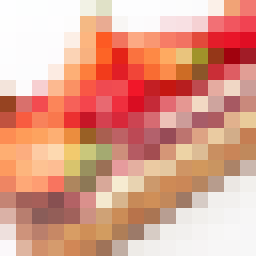

元画像↓


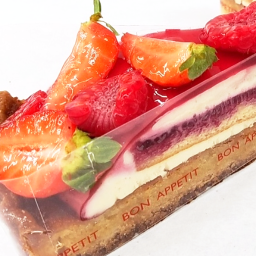

In [500]:
img_mosaic = img.copy()
h,w,_ = img.shape
size = 5
size = np.power(2, size)    # 画像の縦横512割り切れるように
for x in list(range(int(w/size))):
  for y in list(range(int(h/size))):
    img_mosaic[x*size:(x+1)*size, y*size:(y+1)*size, :] = \
    np.mean(img[x*size:(x+1)*size, y*size:(y+1)*size, :], axis=(0, 1)).astype(np.uint8)
print('モザイク↓')
imshow(img_mosaic)
print('元画像↓')
imshow(img)

### ディザリング
制限された色数でそれ以上の色調を表現する手法

#### [組織的ディザ法](http://hooktail.org/computer/index.php?%A5%CF%A1%BC%A5%D5%A5%C8%A1%BC%A5%F3%BD%E8%CD%FD%28%A5%C7%A5%A3%A5%B6%CB%A1%29)
グレースケール画像(0~255)を疑似グレースケール二値化画像(0 or 255)にする  
Bayer型 / ハーフトーン型 / Screw型

In [0]:
def dither(get_img, filter):
  img_dither = get_img.copy()
  h,w,_ = img.shape
  if(get_img.ndim == 2):    # gray_scale
    length = 4 * 4
  if(get_img.ndim == 3):    # BGR color
    length = 4 * 4 * 3
    filter = np.dstack([filter,filter,filter])    # 3チャンネルに拡張(4,4,3) 
    
  for x in list(range(int(w/4))):
    for y in list(range(int(h/4))):
      dst = (img_dither[x*4:(x+1)*4, y*4:(y+1)*4] > filter).flatten()    # 要素ごとに比較
      temp = np.zeros(length)
      for i, bool in enumerate(dst):
        temp[i] = (255 if bool else 0)    # bool -> int
      temp = np.reshape(temp, filter.shape)
      img_dither[x*4:(x+1)*4, y*4:(y+1)*4] = temp
      
  return img_dither

In [0]:
bayer = np.array([[0, 8, 2, 10],
                 [12, 4, 14, 6],
                 [3, 11, 1, 9],
                 [15, 7, 13, 5]]) * 16   # 256階調マトリクス

halftone = np.array([[10, 4, 6, 8],
                     [12, 0, 2, 14],
                     [7, 9, 11, 5],
                     [3, 15, 13, 1]]) * 16

screw = np.array([[13, 7, 6, 12],
                  [8, 1, 0, 5],
                  [9, 2, 3, 4],
                  [14, 10, 11, 15]]) * 16

グレースケール画像に適用してみる

元画像↓


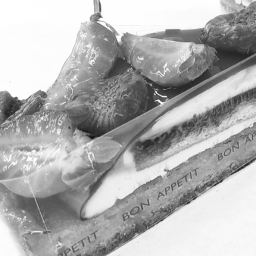

Bayer型↓


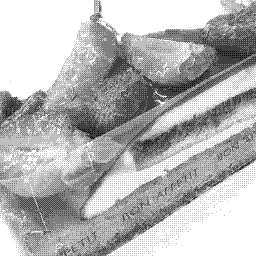

ハーフトーン型↓


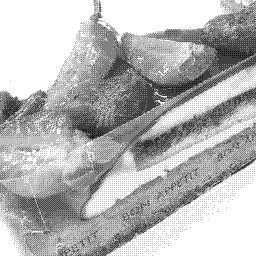

Screw型↓


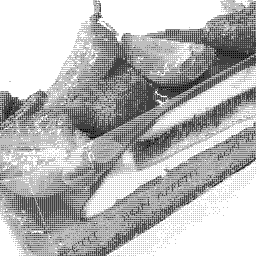

In [503]:
img_bayer = dither(img_gray, bayer)
img_halftone = dither(img_gray, halftone)
img_screw = dither(img_gray, screw)

print('元画像↓')
imshow(img_gray)
print('Bayer型↓')
imshow(img_bayer)
print('ハーフトーン型↓')
imshow(img_halftone)
print('Screw型↓')
imshow(img_screw)

カラー画像に適用した場合，256\*256\*256 = 16777216 (**24bit color**)が  
2\*2\*2 = 8 (**3bit color**)で表現できる

元画像↓


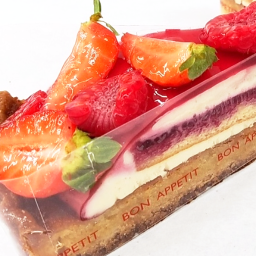

Bayer型↓


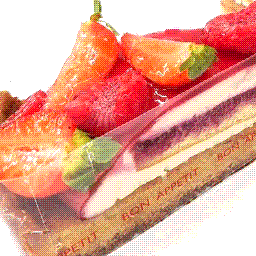

ハーフトーン型↓


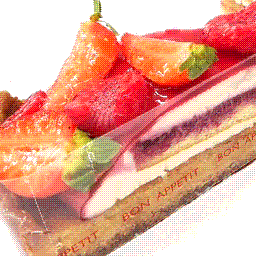

Screw型↓


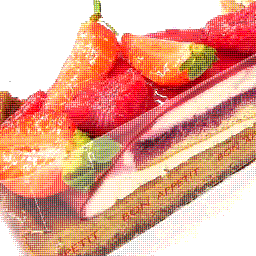

In [504]:
img_bayer = dither(img, bayer)
img_halftone = dither(img, halftone)
img_screw = dither(img, screw)

print('元画像↓')
imshow(img)
print('Bayer型↓')
imshow(img_bayer)
print('ハーフトーン型↓')
imshow(img_halftone)
print('Screw型↓')
imshow(img_screw)

#### [ランダムディザ法](http://blog.nariyu.jp/2015/01/canvas-image-effects/#fx-random-dither)
明るさを確立として計算する方法．  
画素ごと0~255を用いて確率的に0 or 255を決める．  
画素値が128のとき，50%の確率で白か黒．  
輝度から算出するので，カラー画像を入れても白黒が出る．

gray scale画像入力↓


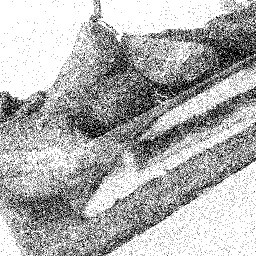

color画像入力↓


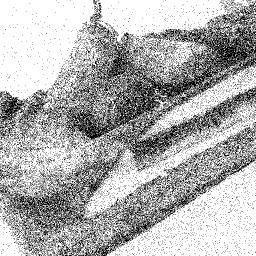

In [505]:
def rdither(get_img):
  img_rdither = get_img.copy()
  h,w,_ = img.shape
  if(get_img.ndim == 3):    # BGR
    img_rdither = img_rdither[:,:,2] * 0.298912 + img_rdither[:,:,1] * 0.586611 + img_rdither[:,:,0] * 0.114478
  
  for x in list(range(w)):
    for y in list(range(h)):
      if img_rdither[x,y] > np.random.rand() * 255:    # 乱数で判定
        img_rdither[x,y] = 255
      else:
        img_rdither[x,y] = 0
  return img_rdither

img_r = rdither(img_gray)
print('gray scale画像入力↓')
imshow(img_r)
img_r = rdither(img)
print('color画像入力↓')
imshow(img_r)

#### [誤差拡散法(Floyd–Steinberg dithering)](http://hooktail.org/computer/index.php?%A5%CF%A1%BC%A5%D5%A5%C8%A1%BC%A5%F3%BD%E8%CD%FD%28%B8%ED%BA%B9%B3%C8%BB%B6%CB%A1%29)
0 or 255にしたときの元の画素値との誤差を周りの画素に拡散する処理方法  
誤差拡散パターンは[ほかにもあります](https://ja.wikipedia.org/wiki/%E3%83%87%E3%82%A3%E3%82%B6#%E3%82%A2%E3%83%AB%E3%82%B4%E3%83%AA%E3%82%BA%E3%83%A0)
が，一番使われているらしいものを実装しました

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in ubyte_scalars


gray scale画像入力↓


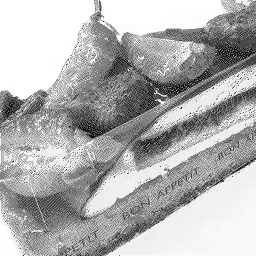

color画像入力↓


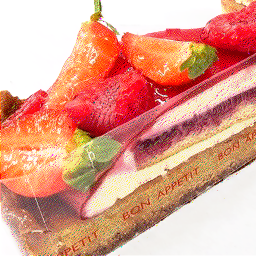

In [506]:
def error_diffusion(get_img):
  img_ED = get_img.copy()
  h,w,_ = img.shape

  for x in list(range(w)):
    for y in list(range(h)):
      if(get_img.ndim == 3):
        e = np.zeros(3)
        for i in list(range(3)):
          img_ED[x,y][i], e[i] = (255, img_ED[x,y][i]-255) if img_ED[x,y][i] > 127 else (0, img_ED[x,y][i])
      else:
        img_ED[x,y], e = (255, img_ED[x,y]-255) if img_ED[x,y] > 127 else (0, img_ED[x,y])

      if x != w-1:
        img_ED[x+1,y] += (5/16 * e).astype(np.uint8)
      if y != h-1:
        img_ED[x,y+1] += (5/16 * e).astype(np.uint8)
        if x != 0:
          img_ED[x-1,y+1] += (3/16 * e).astype(np.uint8)
        if x != w-1:
          img_ED[x+1,y+1] += (3/16 * e).astype(np.uint8)
  return img_ED

img_ED = error_diffusion(img_gray)
print('gray scale画像入力↓')
imshow(img_ED)
img_ED = error_diffusion(img)
print('color画像入力↓')
imshow(img_ED)